<a href="https://colab.research.google.com/github/AmirSamanMirjalili/Robotics-Exercise/blob/main/Code/E4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install symforce 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


# Importing Libraries and Defining Forward Kinematics Function


Here we imports necessary libraries and defines the n_link_forward_kinematics function. This function computes the forward kinematics for an n-link robot using the Product of Exponentials (PoE) formula. It takes joint angles, screw axes parameters, initial transformation parameters, and an epsilon value as inputs, and returns the homogeneous transformation matrix representing the end-effector configuration in the space frame.
The function iterates through each joint, creates Pose3 objects from screw axes, and multiplies them to get the final transformation. It then applies the initial transformation to get the end-effector pose.

In [2]:
import symforce

symforce.set_symbolic_api("sympy")

import symforce.symbolic as sf
from symforce.notebook_util import display
from symforce import geo
from symforce import values
from symforce.geo.unsupported.pose3_se3 import Pose3_SE3

def n_link_forward_kinematics(joint_angles: values.Values, screw_axes_params: values.Values, M_params: values.Values, epsilon: sf.Scalar):
    """
    Computes the forward kinematics for an n-link robot using the Product of Exponentials (PoE) formula,
    with symbolic parameters for joint angles, screw axes, and the initial transformation.

    Args:
        joint_angles: A Values object containing symbolic joint angles, with keys "q0", "q1", etc.
        screw_axes_params: A Values object containing symbolic parameters for the screw axes.
                         Each key should be of the form "S{i}", where i is the joint index,
                         and the value should be a 6-vector representing the screw axis [omega_x, omega_y, omega_z, v_x, v_y, v_z].
        M_params: A Values object containing symbolic parameters for the initial transformation matrix M.
                  The keys should be "R" for the rotation (as a 3-vector Euler angles) and "t" for the translation (as a 3-vector).
        epsilon: A small number to handle singularities in Rot3.from_tangent.

    Returns:
        The homogeneous transformation matrix representing the end-effector configuration in the space frame.
    """
    T = sf.Pose3.identity()
    n = len(joint_angles)

    for i in range(n):
        # Extract screw axis parameters and joint angle from Values objects
        S = screw_axes_params[f"S{i+1}"]
        q = joint_angles[f"q{i+1}"]

        # Create se3 element (6x1 vector)
        se3_element = sf.Matrix61(S * q)

        # Create a Pose3_SE3 object from the se3 element
        pose3_se3 = Pose3_SE3.from_tangent(se3_element, epsilon=epsilon)

        # Convert Pose3_SE3 to Pose3
        pose3 = sf.Pose3(R=pose3_se3.R, t=pose3_se3.t)

        # Update the transformation
        T = T * pose3

    # Construct the initial transformation matrix from symbolic parameters
    R = geo.Rot3.from_yaw_pitch_roll(*M_params["R"])
    t = geo.V3(M_params["t"])
    M = geo.Pose3(R=R, t=t)

    # Multiply with the initial transformation matrix
    T = T * M

    # Convert to homogeneous matrix at the end
    return T.to_homogenous_matrix()

# Example usage (adjust as needed for your specific case)
joint_angles = values.Values(
    q1=sf.Symbol("q1"),
    q2=sf.Symbol("q2"),
    q3=sf.Symbol("q3"),
)

screw_axes_params = values.Values(
    S1=sf.V6.symbolic("S1"),
    S2=sf.V6.symbolic("S2"),
    S3=sf.V6.symbolic("S3"),
)

M_params = values.Values(
    R=sf.V3.symbolic("R"),
    t=sf.V3.symbolic("t"),
)

epsilon = sf.numeric_epsilon
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

display(f"End-Effector Pose:\n{end_effector_pose}")

'End-Effector Pose:\nMatrix([\n[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

# Setting Up 3-DOF Robot Configuration

Here we defines the setup_3dof_robot() function, which sets up the configuration for a 3-DOF (Degrees of Freedom) robot. It defines symbolic variables for joint angles and link lengths, and creates Values objects for joint angles, screw axes parameters, and initial transformation parameters.
The robot has two revolute joints (rotating around y and x axes) and one prismatic joint (moving along z-axis). The function returns these parameters along with a symbolic variable for the end-effector's initial z-position ($L_0$).

In [3]:
def setup_3dof_robot():
    # Define symbolic variables for joint angles and link lengths
    theta1, theta2, d = sf.symbols("theta1 theta2 d",positive=True)
    # a1, a2, a3 = sf.symbols("a1 a2 a3")
    L0 = sf.symbols("L0",positive=True)  # EE position in base frame when in home position

    # Define joint angles
    joint_angles = values.Values(
        q1=theta1,
        q2=theta2,
        q3=d
    )

# Define screw axes for planar RRR robot
    # axis of rotation for revolute joint1
    omega1 = sf.V3(0, 1, 0)

    # Calculate v for each joint
    q1 = sf.V3(0, 0, 0)  # Point on the axis of joint 1
    v1 = -omega1.cross(q1)

    # axis of rotation for revolute joint2
    omega2 = sf.V3(1, 0, 0)

    q2 = sf.V3(0, 0, 0)  # Point on the axis of joint 2
    v2 = -omega2.cross(q2)


    # axis of rotation for prismatic joint3
    omega3 = sf.V3(0, 0, 0)

    v3 = sf.V3(0, 0, 1)  # Prismatic joint moves along z-axis

    screw_axes_params = values.Values(
        S1=sf.V6(omega1.to_flat_list() + v1.to_flat_list()),
        S2=sf.V6(omega2.to_flat_list() + v2.to_flat_list()),
        S3=sf.V6(omega3.to_flat_list() + v3.to_flat_list())
    )

    # Define initial end-effector transformation (identity in this case)
    M_params = values.Values(
        R=sf.V3([0, 0, 0]),  # No initial rotation
        t=sf.V3([0, 0, L0])  # End-effector at full extension
    )

    return joint_angles, screw_axes_params, M_params, (L0)



# Computing Forward Kinematics

This cell uses the previously defined functions to compute the forward kinematics of the 3-DOF robot. It first sets up the robot configuration, then computes the end-effector pose using the n_link_forward_kinematics function. Finally, it displays the full end-effector pose, as well as the rotation matrix and translation vector separately.

In [4]:
joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()



epsilon = sf.numeric_epsilon  # Small number to handle singularities in Rot3.from_tangent
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)


display(f"End-Effector Pose:\n{end_effector_pose.simplify}")

# Rotation matrix

R = end_effector_pose[:3, :3]
display("Rotation Matrix:")
display(R)



# Translation vector
t = end_effector_pose[:3, 3]
display("Translation vector")
display(t)



'End-Effector Pose:\n<bound method Matrix.simplify of Matrix([\n[                                                                                    -2.0*theta1**2*theta2**2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)**2*sin(sqrt(theta2**2 + 4.93038065763132e-30)/2)**2/((theta1**2 + 4.93038065763132e-30)*(theta2**2 + 4.93038065763132e-30)) - 2.0*theta1**2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)**2*cos(sqrt(theta2**2 + 4.93038065763132e-30)/2)**2/(theta1**2 + 4.93038065763132e-30) + 1,                                                                                                                                                       4.0*theta1*theta2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)*sin(sqrt(theta2**2 + 4.93038065763132e-30)/2)*cos(sqrt(theta1**2 + 4.93038065763132e-30)/2)*cos(sqrt(theta2**2 + 4.93038065763132e-30)/2)/(sqrt(theta1**2 + 4.93038065763132e-30)*sqrt(theta2**2 + 4.93038065763132e-30)), -2.0*theta1*theta2**2*sin(sqrt(theta1**2 + 4.93038065763132e-30)/2)*s

'Rotation Matrix:'

⎡                                                   ⎛   ______________________
⎢                                                   ⎜  ╱   2                  
⎢                                         2   2    2⎜╲╱  θ₁  + 4.9303806576313
⎢                                   2.0⋅θ₁ ⋅θ₂ ⋅sin ⎜─────────────────────────
⎢                                                   ⎝               2         
⎢                                 - ──────────────────────────────────────────
⎢                                                  ⎛  2                       
⎢                                                  ⎝θ₁  + 4.93038065763132e-30
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

'Translation vector'

⎡   ⎛                ⎛   ____________________________⎞     ⎛   _______________
⎢   ⎜                ⎜  ╱   2                        ⎟     ⎜  ╱   2           
⎢   ⎜           2    ⎜╲╱  θ₁  + 4.93038065763132e-30 ⎟    2⎜╲╱  θ₂  + 4.930380
⎢   ⎜  2.0⋅θ₁⋅θ₂ ⋅sin⎜───────────────────────────────⎟⋅sin ⎜──────────────────
⎢   ⎜                ⎝               2               ⎠     ⎝               2  
⎢L₀⋅⎜- ───────────────────────────────────────────────────────────────────────
⎢   ⎜                                    ____________________________         
⎢   ⎜                                   ╱   2                         ⎛  2    
⎢   ⎝                                 ╲╱  θ₁  + 4.93038065763132e-30 ⋅⎝θ₂  + 4
⎢                                                                             
⎢   ⎛                 ⎛   ____________________________⎞    ⎛   _______________
⎢   ⎜                 ⎜  ╱   2                        ⎟    ⎜  ╱   2           
⎢   ⎜        2       2⎜╲╱  θ₁  + 4.93038065763132e-3

# Calculating S Matrices

This cell defines a function calculate_S_matrix that computes the 4x4 matrix [S_i] from a 6-dimensional screw axis. It then calculates these matrices for each joint of the 3-DOF robot and displays them. These matrices represent the infinitesimal motion of each joint and are used in the Product of Exponentials formula for forward kinematics.

In [5]:
import sympy as sp

def calculate_S_matrix(screw_axis):
    """
    Calculate the 4x4 matrix [S_i] from a 6-dimensional screw axis.

    Args:
    screw_axis (list): A 6-dimensional list representing [ω_x, ω_y, ω_z, v_x, v_y, v_z]

    Returns:
    sp.Matrix: The 4x4 matrix [S_i]
    """
    omega = sp.Matrix(screw_axis[:3])
    v = sp.Matrix(screw_axis[3:])

    omega_skew = sp.Matrix([
        [0, -omega[2], omega[1]],
        [omega[2], 0, -omega[0]],
        [-omega[1], omega[0], 0]
    ])

    S_matrix = sp.Matrix.zeros(4)
    S_matrix[:3, :3] = omega_skew
    S_matrix[:3, 3] = v

    return S_matrix

# Setup the robot
joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()

# Calculate [S_i] for each joint
S_matrices = []
for i in range(3):
    screw_axis = screw_axes_params[f'S{i+1}']
    S_matrix = calculate_S_matrix(screw_axis)
    S_matrices.append(S_matrix)

# Display the results
for i, S_matrix in enumerate(S_matrices):
    display(f"[S_{i}] matrix:")
    display(S_matrix)

'[S_0] matrix:'

⎡0   0  1  0⎤
⎢           ⎥
⎢0   0  0  0⎥
⎢           ⎥
⎢-1  0  0  0⎥
⎢           ⎥
⎣0   0  0  0⎦

'[S_1] matrix:'

⎡0  0  0   0⎤
⎢           ⎥
⎢0  0  -1  0⎥
⎢           ⎥
⎢0  1  0   0⎥
⎢           ⎥
⎣0  0  0   0⎦

'[S_2] matrix:'

⎡0  0  0  0⎤
⎢          ⎥
⎢0  0  0  0⎥
⎢          ⎥
⎢0  0  0  1⎥
⎢          ⎥
⎣0  0  0  0⎦

# Verifying Forward Kinematics

This cell defines functions to verify the correctness of the forward kinematics calculations. The verify_forward_kinematics function takes joint angle values and an expected end-effector position, computes the actual position using the forward kinematics function, and compares it with the expected position.
The cell then runs four test cases for different robot configurations:
- Robot arm rotates around q1 for 90 degree
- Robot arm straight up
- Robot arm bent 90 degrees around q2
- Robot arm straight up  with extension

![3dof.png](attachment:3dof.png)


For each test case, it displays the configuration, expected position, actual position, and whether they match within a small tolerance.
This verification helps ensure that the forward kinematics calculations are correct for various robot poses.


In [6]:
import math

def is_close(v1, v2, epsilon=1e-6):
    return all(abs(a - b) < epsilon for a, b in zip(v1, v2))

def verify_forward_kinematics(q1_val, q2_val, q3_val, expected_position):
    # Setup the robot
    joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()

    # Create a dictionary for substitutions
    substitutions = {
        joint_angles['q1']: q1_val,
        joint_angles['q2']: q2_val,
        joint_angles['q3']: q3_val,
        L0: 1.0  # Assuming L0 = 1 unit
    }

    # Compute forward kinematics
    epsilon = sf.numeric_epsilon
    end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

    # Apply substitutions
    end_effector_pose_subbed = end_effector_pose.subs(substitutions)

    # Extract the position vector
    position = end_effector_pose_subbed[:3, 3].evalf()

    # Compare with expected position
    expected = sf.V3(expected_position)
    actual = sf.V3(position)
    is_close_result = is_close(actual, expected, epsilon=1e-6)

    display("Configuration:")
    display(f"q1 = {q1_val:.2f}, q2 = {q2_val:.2f}, q3 = {q3_val:.2f}")

    display("Expected position:")
    display(expected)

    display("Actual position:")
    display(actual)

    display("Match:")
    display("Yes" if is_close_result else "No")

    display("---")

# Test cases
verify_forward_kinematics(math.pi/2, 0, 0, [1, 0, 0])  # Robot arm rotates around q1 for 90 degree
verify_forward_kinematics(0, 0, 0, [0, 0, 1])  # Robot arm straight up
verify_forward_kinematics(0, math.pi/2, 0, [0, -1, 0])  # Robot arm bent 90 degrees around q2
verify_forward_kinematics(0, 0, 0.5, [0, 0, 1.5])  # Robot arm straight up  with extension

'Configuration:'

'q1 = 1.57, q2 = 0.00, q3 = 0.00'

'Expected position:'

⎡1⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

'Actual position:'

⎡        1.0         ⎤
⎢                    ⎥
⎢         0          ⎥
⎢                    ⎥
⎣2.22044604925031e-16⎦

'Match:'

'Yes'

'---'

'Configuration:'

'q1 = 0.00, q2 = 0.00, q3 = 0.00'

'Expected position:'

⎡0⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣1⎦

'Actual position:'

⎡ 0 ⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣1.0⎦

'Match:'

'Yes'

'---'

'Configuration:'

'q1 = 0.00, q2 = 1.57, q3 = 0.00'

'Expected position:'

⎡0 ⎤
⎢  ⎥
⎢-1⎥
⎢  ⎥
⎣0 ⎦

'Actual position:'

⎡         0          ⎤
⎢                    ⎥
⎢        -1.0        ⎥
⎢                    ⎥
⎣2.22044604925031e-16⎦

'Match:'

'Yes'

'---'

'Configuration:'

'q1 = 0.00, q2 = 0.00, q3 = 0.50'

'Expected position:'

⎡ 0 ⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣1.5⎦

'Actual position:'

⎡ 0 ⎤
⎢   ⎥
⎢ 0 ⎥
⎢   ⎥
⎣1.5⎦

'Match:'

'Yes'

'---'

# Exporting code into maple for simplification



In [7]:
import sympy as sp
from sympy import sympify, maple_code, Symbol

def remove_small_values(expr, threshold=1e-10):
    if isinstance(expr, sp.Number):
        return sp.Float(0) if abs(expr) < threshold else expr
    elif isinstance(expr, sp.Add):
        return sp.Add(*[remove_small_values(arg, threshold) for arg in expr.args])
    elif isinstance(expr, sp.Mul):
        cleaned_args = [remove_small_values(arg, threshold) for arg in expr.args]
        if any(arg == 0 for arg in cleaned_args):
            return sp.Float(0)
        return sp.Mul(*cleaned_args)
    elif isinstance(expr, sp.Pow):
        base = remove_small_values(expr.base, threshold)
        exp = remove_small_values(expr.exp, threshold)
        if exp == 0.5:  # This is a square root
            if isinstance(base, sp.Add):
                significant_terms = [term for term in base.args if not (isinstance(term, sp.Number) and abs(term) < threshold)]
                if len(significant_terms) == 0:
                    return sp.Float(0)
                elif len(significant_terms) == 1:
                    return sp.sqrt(significant_terms[0])
                else:
                    return sp.sqrt(sp.Add(*significant_terms))
            return sp.sqrt(base)
        return base ** exp
    elif isinstance(expr, (sp.sin, sp.cos, sp.tan)):
        return expr.func(remove_small_values(expr.args[0], threshold))
    else:
        return expr

def clean_expression(expr):
    cleaned_expr = remove_small_values(expr)
    return sp.simplify(cleaned_expr)

def symforce_to_maple(expression):
    sympy_expr = sympify(str(expression))
    epsilon = Symbol('epsilon')
    sympy_expr = sympy_expr.subs(sf.numeric_epsilon, epsilon)
    cleaned_expr = clean_expression(sympy_expr)
    maple_str = maple_code(cleaned_expr)
    return maple_str

joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()
epsilon = sf.numeric_epsilon
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

maple_expressions = []
maple_expressions.append("# Robot Kinematics in Maple\n")
maple_expressions.append("with(LinearAlgebra):")
maple_expressions.append("# Assume positive values for parameters\n assume(theta1 > 0, theta2 > 0, d > 0, L0 > 0):")
maple_expressions.append("T := Matrix(4,4):")

for i in range(4):
    for j in range(4):
        maple_expr = symforce_to_maple(end_effector_pose[i, j])
        maple_expressions.append(f"T[{i+1},{j+1}] := {maple_expr};")

maple_expressions.append("T := simplify(T);")
maple_expressions.append("print(\"Full Transformation Matrix:\");")
maple_expressions.append("print(T);")

# Extract and print rotation matrix
maple_expressions.append("\n# Extract Rotation Matrix")
maple_expressions.append("R := SubMatrix(T, 1..3, 1..3);")
maple_expressions.append("print(\"Rotation Matrix:\");")
maple_expressions.append("print(R);")

# Extract and print position vector
maple_expressions.append("\n# Extract Position Vector")
maple_expressions.append("p := Vector([T[1,4], T[2,4], T[3,4]]);")
maple_expressions.append("print(\"Position Vector:\");")
maple_expressions.append("print(p);")

# Write to Maple worksheet file
with open("robot_kinematics.mw", "w") as f:
    for expr in maple_expressions:
        f.write(expr + "\n")

print("Maple worksheet 'robot_kinematics.mw' has been generated.")

Maple worksheet 'robot_kinematics.mw' has been generated.


# Inverse Kinematics Analysis

## Overview

The inverse kinematics solution for our 3-DOF robot yields 8 distinct solution sets. Each set represents a possible configuration of joint angles (θ₁, θ₂, d) that could position the end-effector at the desired location.

## Solution Sets

We obtained 8 solution sets, each containing values for θ₁, θ₂, and d. These solutions may include both real and imaginary parts due to the nature of the mathematical calculations involved.

### Interpretation of Solutions

1. **Real Solutions**: Represent physically achievable robot configurations.
2. **Complex Solutions**: Solutions with non-zero imaginary parts are not physically realizable.

## Analysis of Solution Sets

For each solution set:

1. **θ₁ (theta1)**: Rotation angle of the first joint
2. **θ₂ (theta2)**: Rotation angle of the second joint
3. **d**: Extension of the prismatic joint

### Example Solution Set

```python
Solution set 1:
θ₁ = 1.81577498992176 - 2.16586762356905e-15⋅ⅈ
θ₂ = 2.37134832517544 - 2.70609120709803e-16⋅ⅈ
d = 1.87228132326901 - 8.01186962950885e-16⋅ⅈ
```

#### Interpretation:
- All values have very small imaginary parts (on the order of 10⁻¹⁵ to 10⁻¹⁶).
- These can be considered essentially real solutions due to computational precision limitations.
- Rounded real values:
  - θ₁ ≈ 1.81578 radians
  - θ₂ ≈ 2.37135 radians
  - d ≈ 1.87228 units

## Significance of Multiple Solutions

1. **Robot Configuration**: Each solution represents a different arm configuration that achieves the same end-effector position.
2. **Path Planning**: Multiple solutions allow for choosing optimal configurations based on factors like joint limits, obstacle avoidance, etc.
3. **Singularities**: Some solutions might be near singularities, which should be avoided in practical applications.

## Handling Complex Solutions

1. **Filtering**: Discard solutions with significant imaginary parts.
2. **Thresholding**: Set a small threshold (e.g., 10⁻⁹) to consider solutions as real if imaginary parts are below this value.
3. **Physical Constraints**: Apply joint limits and workspace constraints to further filter solutions.



In [8]:
def solve_inverse_kinematics():
    # Setup the robot
    joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()

    # Compute forward kinematics
    epsilon = sf.numeric_epsilon
    end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

    # Extract the position components
    x = sf.simplify(sf.expand(clean_expression(end_effector_pose[0, 3]),Trig=True))
    y = clean_expression(end_effector_pose[1, 3])
    z = clean_expression(end_effector_pose[2, 3])


    # Define symbolic variables for the target position
    x_target, y_target, z_target = sf.symbols("x_target y_target z_target")

    # Define the equations to solve
    eq1 = x - x_target
    eq2 = y - y_target
    eq3 = z - z_target

    # Extract the joint angle symbols
    theta1 = joint_angles['q1']
    theta2 = joint_angles['q2']
    d = joint_angles['q3']

    # Solve the system of equations
    solution = sf.solve([eq1, eq2, eq3], [theta1, theta2, d])

    return solution

# Solve and print the results
ik_solution = solve_inverse_kinematics()
print("Inverse Kinematics Solution:")
for i, sol in enumerate(ik_solution, 1):
    display(f"Solution set {i}:")
    display("theta1 =", sol[0])
    display("theta2 =", sol[1])
    display("d =", sol[2])
    print()

Inverse Kinematics Solution:


'Solution set 1:'

'theta1 ='

                       ⎛            ⎛     ⎛        ___________________________
                       ⎜            ⎜     ⎜       ╱                           
                       ⎜            ⎜     ⎜      ╱          2           2     
                       ⎜            ⎜     ⎜     ╱   x_target  - y_target  - 2.
                       ⎜x_target⋅tan⎜ⅈ⋅log⎜-   ╱    ──────────────────────────
                       ⎜            ⎜     ⎜   ╱                               
                       ⎜            ⎝     ⎝ ╲╱                            x_ta
3.14159265358979 - asin⎜──────────────────────────────────────────────────────
                       ⎝                                                  y_ta

____________________________________________________⎞⎞⎞
                                    0.5             ⎟⎟⎟
             ⎛        2           2⎞              2 ⎟⎟⎟
0⋅ⅈ⋅y_target⋅⎝x_target  + z_target ⎠    + z_target  ⎟⎟⎟
─────────────────────────────────────────────────── ⎟⎟⎟
    2   

'theta2 ='

      ⎛        _______________________________________________________________
      ⎜       ╱                                                               
      ⎜      ╱          2           2                  ⎛        2           2⎞
      ⎜     ╱   x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z_target ⎠
-ⅈ⋅log⎜-   ╱    ──────────────────────────────────────────────────────────────
      ⎜   ╱                                   2           2           2       
      ⎝ ╲╱                            x_target  + y_target  + z_target        

________________⎞
0.5             ⎟
              2 ⎟
    + z_target  ⎟
─────────────── ⎟
                ⎟
                ⎠

'd ='

                                                    y_target                  
-L₀ + ────────────────────────────────────────────────────────────────────────
         ⎛     ⎛        ______________________________________________________
         ⎜     ⎜       ╱                                                      
         ⎜     ⎜      ╱          2           2                  ⎛        2    
         ⎜     ⎜     ╱   x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z
      sin⎜ⅈ⋅log⎜-   ╱    ─────────────────────────────────────────────────────
         ⎜     ⎜   ╱                                   2           2          
         ⎝     ⎝ ╲╱                            x_target  + y_target  + z_targe

                           
───────────────────────────
_________________________⎞⎞
         0.5             ⎟⎟
       2⎞              2 ⎟⎟
_target ⎠    + z_target  ⎟⎟
──────────────────────── ⎟⎟
 2                       ⎟⎟
t                        ⎠⎠

'Solution set 2:'

'theta1 ='

                       ⎛            ⎛     ⎛        ___________________________
                       ⎜            ⎜     ⎜       ╱                           
                       ⎜            ⎜     ⎜      ╱          2           2     
                       ⎜            ⎜     ⎜     ╱   x_target  - y_target  + 2.
                       ⎜x_target⋅tan⎜ⅈ⋅log⎜-   ╱    ──────────────────────────
                       ⎜            ⎜     ⎜   ╱                               
                       ⎜            ⎝     ⎝ ╲╱                            x_ta
3.14159265358979 - asin⎜──────────────────────────────────────────────────────
                       ⎝                                                  y_ta

____________________________________________________⎞⎞⎞
                                    0.5             ⎟⎟⎟
             ⎛        2           2⎞              2 ⎟⎟⎟
0⋅ⅈ⋅y_target⋅⎝x_target  + z_target ⎠    + z_target  ⎟⎟⎟
─────────────────────────────────────────────────── ⎟⎟⎟
    2   

'theta2 ='

      ⎛        _______________________________________________________________
      ⎜       ╱                                                               
      ⎜      ╱          2           2                  ⎛        2           2⎞
      ⎜     ╱   x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z_target ⎠
-ⅈ⋅log⎜-   ╱    ──────────────────────────────────────────────────────────────
      ⎜   ╱                                   2           2           2       
      ⎝ ╲╱                            x_target  + y_target  + z_target        

________________⎞
0.5             ⎟
              2 ⎟
    + z_target  ⎟
─────────────── ⎟
                ⎟
                ⎠

'd ='

                                                    y_target                  
-L₀ + ────────────────────────────────────────────────────────────────────────
         ⎛     ⎛        ______________________________________________________
         ⎜     ⎜       ╱                                                      
         ⎜     ⎜      ╱          2           2                  ⎛        2    
         ⎜     ⎜     ╱   x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z
      sin⎜ⅈ⋅log⎜-   ╱    ─────────────────────────────────────────────────────
         ⎜     ⎜   ╱                                   2           2          
         ⎝     ⎝ ╲╱                            x_target  + y_target  + z_targe

                           
───────────────────────────
_________________________⎞⎞
         0.5             ⎟⎟
       2⎞              2 ⎟⎟
_target ⎠    + z_target  ⎟⎟
──────────────────────── ⎟⎟
 2                       ⎟⎟
t                        ⎠⎠

'Solution set 3:'

'theta1 ='

                       ⎛               ⎛       ⎛                              
                       ⎜               ⎜       ⎜        2           2         
                       ⎜               ⎜       ⎜x_target  - y_target  - 2.0⋅ⅈ⋅
                       ⎜ⅈ⋅x_target⋅tanh⎜0.5⋅log⎜──────────────────────────────
                       ⎜               ⎜       ⎜                              
                       ⎜               ⎝       ⎝                      x_target
3.14159265358979 - asin⎜──────────────────────────────────────────────────────
                       ⎝                                                y_targ

            _______________________            ⎞⎞⎞
           ╱         2           2            2⎟⎟⎟
y_target⋅╲╱  x_target  + z_target   + z_target ⎟⎟⎟
───────────────────────────────────────────────⎟⎟⎟
2           2           2                      ⎟⎟⎟
  + y_target  + z_target                       ⎠⎠⎟
─────────────────────────────────────────────────⎟
et        

'theta2 ='

          ⎛                                          _______________________  
          ⎜        2           2                    ╱         2           2   
          ⎜x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_target   +
-0.5⋅ⅈ⋅log⎜───────────────────────────────────────────────────────────────────
          ⎜                              2           2           2            
          ⎝                      x_target  + y_target  + z_target             

          ⎞
         2⎟
 z_target ⎟
──────────⎟
          ⎟
          ⎠

'd ='

                                               ⅈ⋅y_target                     
-L₀ - ────────────────────────────────────────────────────────────────────────
          ⎛       ⎛                                          _________________
          ⎜       ⎜        2           2                    ╱         2       
          ⎜       ⎜x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_ta
      sinh⎜0.5⋅log⎜───────────────────────────────────────────────────────────
          ⎜       ⎜                              2           2           2    
          ⎝       ⎝                      x_target  + y_target  + z_target     

                    
────────────────────
______            ⎞⎞
    2            2⎟⎟
rget   + z_target ⎟⎟
──────────────────⎟⎟
                  ⎟⎟
                  ⎠⎠

'Solution set 4:'

'theta1 ='

                       ⎛               ⎛       ⎛                              
                       ⎜               ⎜       ⎜        2           2         
                       ⎜               ⎜       ⎜x_target  - y_target  + 2.0⋅ⅈ⋅
                       ⎜ⅈ⋅x_target⋅tanh⎜0.5⋅log⎜──────────────────────────────
                       ⎜               ⎜       ⎜                              
                       ⎜               ⎝       ⎝                      x_target
3.14159265358979 - asin⎜──────────────────────────────────────────────────────
                       ⎝                                                y_targ

            _______________________            ⎞⎞⎞
           ╱         2           2            2⎟⎟⎟
y_target⋅╲╱  x_target  + z_target   + z_target ⎟⎟⎟
───────────────────────────────────────────────⎟⎟⎟
2           2           2                      ⎟⎟⎟
  + y_target  + z_target                       ⎠⎠⎟
─────────────────────────────────────────────────⎟
et        

'theta2 ='

          ⎛                                          _______________________  
          ⎜        2           2                    ╱         2           2   
          ⎜x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_target   +
-0.5⋅ⅈ⋅log⎜───────────────────────────────────────────────────────────────────
          ⎜                              2           2           2            
          ⎝                      x_target  + y_target  + z_target             

          ⎞
         2⎟
 z_target ⎟
──────────⎟
          ⎟
          ⎠

'd ='

                                               ⅈ⋅y_target                     
-L₀ - ────────────────────────────────────────────────────────────────────────
          ⎛       ⎛                                          _________________
          ⎜       ⎜        2           2                    ╱         2       
          ⎜       ⎜x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_ta
      sinh⎜0.5⋅log⎜───────────────────────────────────────────────────────────
          ⎜       ⎜                              2           2           2    
          ⎝       ⎝                      x_target  + y_target  + z_target     

                    
────────────────────
______            ⎞⎞
    2            2⎟⎟
rget   + z_target ⎟⎟
──────────────────⎟⎟
                  ⎟⎟
                  ⎠⎠

'Solution set 5:'

'theta1 ='

    ⎛            ⎛     ⎛        ______________________________________________
    ⎜            ⎜     ⎜       ╱                                              
    ⎜            ⎜     ⎜      ╱          2           2                  ⎛     
    ⎜            ⎜     ⎜     ╱   x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅⎝x_tar
    ⎜x_target⋅tan⎜ⅈ⋅log⎜-   ╱    ─────────────────────────────────────────────
    ⎜            ⎜     ⎜   ╱                                   2           2  
    ⎜            ⎝     ⎝ ╲╱                            x_target  + y_target  +
asin⎜─────────────────────────────────────────────────────────────────────────
    ⎝                                                  y_target               

_________________________________⎞⎞⎞
                 0.5             ⎟⎟⎟
   2           2⎞              2 ⎟⎟⎟
get  + z_target ⎠    + z_target  ⎟⎟⎟
──────────────────────────────── ⎟⎟⎟
         2                       ⎟⎟⎟
 z_target                        ⎠⎠⎟
─────────────────────────────

'theta2 ='

      ⎛        _______________________________________________________________
      ⎜       ╱                                                               
      ⎜      ╱          2           2                  ⎛        2           2⎞
      ⎜     ╱   x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z_target ⎠
-ⅈ⋅log⎜-   ╱    ──────────────────────────────────────────────────────────────
      ⎜   ╱                                   2           2           2       
      ⎝ ╲╱                            x_target  + y_target  + z_target        

________________⎞
0.5             ⎟
              2 ⎟
    + z_target  ⎟
─────────────── ⎟
                ⎟
                ⎠

'd ='

                                                    y_target                  
-L₀ + ────────────────────────────────────────────────────────────────────────
         ⎛     ⎛        ______________________________________________________
         ⎜     ⎜       ╱                                                      
         ⎜     ⎜      ╱          2           2                  ⎛        2    
         ⎜     ⎜     ╱   x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z
      sin⎜ⅈ⋅log⎜-   ╱    ─────────────────────────────────────────────────────
         ⎜     ⎜   ╱                                   2           2          
         ⎝     ⎝ ╲╱                            x_target  + y_target  + z_targe

                           
───────────────────────────
_________________________⎞⎞
         0.5             ⎟⎟
       2⎞              2 ⎟⎟
_target ⎠    + z_target  ⎟⎟
──────────────────────── ⎟⎟
 2                       ⎟⎟
t                        ⎠⎠

'Solution set 6:'

'theta1 ='

    ⎛            ⎛     ⎛        ______________________________________________
    ⎜            ⎜     ⎜       ╱                                              
    ⎜            ⎜     ⎜      ╱          2           2                  ⎛     
    ⎜            ⎜     ⎜     ╱   x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅⎝x_tar
    ⎜x_target⋅tan⎜ⅈ⋅log⎜-   ╱    ─────────────────────────────────────────────
    ⎜            ⎜     ⎜   ╱                                   2           2  
    ⎜            ⎝     ⎝ ╲╱                            x_target  + y_target  +
asin⎜─────────────────────────────────────────────────────────────────────────
    ⎝                                                  y_target               

_________________________________⎞⎞⎞
                 0.5             ⎟⎟⎟
   2           2⎞              2 ⎟⎟⎟
get  + z_target ⎠    + z_target  ⎟⎟⎟
──────────────────────────────── ⎟⎟⎟
         2                       ⎟⎟⎟
 z_target                        ⎠⎠⎟
─────────────────────────────

'theta2 ='

      ⎛        _______________________________________________________________
      ⎜       ╱                                                               
      ⎜      ╱          2           2                  ⎛        2           2⎞
      ⎜     ╱   x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z_target ⎠
-ⅈ⋅log⎜-   ╱    ──────────────────────────────────────────────────────────────
      ⎜   ╱                                   2           2           2       
      ⎝ ╲╱                            x_target  + y_target  + z_target        

________________⎞
0.5             ⎟
              2 ⎟
    + z_target  ⎟
─────────────── ⎟
                ⎟
                ⎠

'd ='

                                                    y_target                  
-L₀ + ────────────────────────────────────────────────────────────────────────
         ⎛     ⎛        ______________________________________________________
         ⎜     ⎜       ╱                                                      
         ⎜     ⎜      ╱          2           2                  ⎛        2    
         ⎜     ⎜     ╱   x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅⎝x_target  + z
      sin⎜ⅈ⋅log⎜-   ╱    ─────────────────────────────────────────────────────
         ⎜     ⎜   ╱                                   2           2          
         ⎝     ⎝ ╲╱                            x_target  + y_target  + z_targe

                           
───────────────────────────
_________________________⎞⎞
         0.5             ⎟⎟
       2⎞              2 ⎟⎟
_target ⎠    + z_target  ⎟⎟
──────────────────────── ⎟⎟
 2                       ⎟⎟
t                        ⎠⎠

'Solution set 7:'

'theta1 ='

    ⎛               ⎛       ⎛                                          _______
    ⎜               ⎜       ⎜        2           2                    ╱       
    ⎜               ⎜       ⎜x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅╲╱  x_targ
    ⎜ⅈ⋅x_target⋅tanh⎜0.5⋅log⎜─────────────────────────────────────────────────
    ⎜               ⎜       ⎜                              2           2      
    ⎜               ⎝       ⎝                      x_target  + y_target  + z_t
asin⎜─────────────────────────────────────────────────────────────────────────
    ⎝                                                y_target                 

________________            ⎞⎞⎞
  2           2            2⎟⎟⎟
et  + z_target   + z_target ⎟⎟⎟
────────────────────────────⎟⎟⎟
     2                      ⎟⎟⎟
arget                       ⎠⎠⎟
──────────────────────────────⎟
                              ⎠

'theta2 ='

          ⎛                                          _______________________  
          ⎜        2           2                    ╱         2           2   
          ⎜x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_target   +
-0.5⋅ⅈ⋅log⎜───────────────────────────────────────────────────────────────────
          ⎜                              2           2           2            
          ⎝                      x_target  + y_target  + z_target             

          ⎞
         2⎟
 z_target ⎟
──────────⎟
          ⎟
          ⎠

'd ='

                                               ⅈ⋅y_target                     
-L₀ - ────────────────────────────────────────────────────────────────────────
          ⎛       ⎛                                          _________________
          ⎜       ⎜        2           2                    ╱         2       
          ⎜       ⎜x_target  - y_target  - 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_ta
      sinh⎜0.5⋅log⎜───────────────────────────────────────────────────────────
          ⎜       ⎜                              2           2           2    
          ⎝       ⎝                      x_target  + y_target  + z_target     

                    
────────────────────
______            ⎞⎞
    2            2⎟⎟
rget   + z_target ⎟⎟
──────────────────⎟⎟
                  ⎟⎟
                  ⎠⎠

'Solution set 8:'

'theta1 ='

    ⎛               ⎛       ⎛                                          _______
    ⎜               ⎜       ⎜        2           2                    ╱       
    ⎜               ⎜       ⎜x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅╲╱  x_targ
    ⎜ⅈ⋅x_target⋅tanh⎜0.5⋅log⎜─────────────────────────────────────────────────
    ⎜               ⎜       ⎜                              2           2      
    ⎜               ⎝       ⎝                      x_target  + y_target  + z_t
asin⎜─────────────────────────────────────────────────────────────────────────
    ⎝                                                y_target                 

________________            ⎞⎞⎞
  2           2            2⎟⎟⎟
et  + z_target   + z_target ⎟⎟⎟
────────────────────────────⎟⎟⎟
     2                      ⎟⎟⎟
arget                       ⎠⎠⎟
──────────────────────────────⎟
                              ⎠

'theta2 ='

          ⎛                                          _______________________  
          ⎜        2           2                    ╱         2           2   
          ⎜x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_target   +
-0.5⋅ⅈ⋅log⎜───────────────────────────────────────────────────────────────────
          ⎜                              2           2           2            
          ⎝                      x_target  + y_target  + z_target             

          ⎞
         2⎟
 z_target ⎟
──────────⎟
          ⎟
          ⎠

'd ='

                                               ⅈ⋅y_target                     
-L₀ - ────────────────────────────────────────────────────────────────────────
          ⎛       ⎛                                          _________________
          ⎜       ⎜        2           2                    ╱         2       
          ⎜       ⎜x_target  - y_target  + 2.0⋅ⅈ⋅y_target⋅╲╱  x_target  + z_ta
      sinh⎜0.5⋅log⎜───────────────────────────────────────────────────────────
          ⎜       ⎜                              2           2           2    
          ⎝       ⎝                      x_target  + y_target  + z_target     

                    
────────────────────
______            ⎞⎞
    2            2⎟⎟
rget   + z_target ⎟⎟
──────────────────⎟⎟
                  ⎟⎟
                  ⎠⎠

## Workspace Analysis Explanation

### Overview
The workspace analysis is a crucial step in understanding the operational capabilities of a robot. It involves determining the set of all points in 3D space that the robot's end-effector can reach. This analysis provides insights into the robot's range of motion, dexterity, and potential limitations.

### Key Components of the Analysis

1. **Forward Kinematics Utilization**
   - We use the forward kinematics equations to map joint configurations to end-effector positions.
   - This allows us to explore how different joint angles result in various end-effector positions.

2. **Joint Space Sampling**
   - We define ranges for each joint of the robot (two rotational joints and one prismatic joint in this case).
   - These ranges are sampled at regular intervals to create a comprehensive set of joint configurations.

3. **End-Effector Position Calculation**
   - For each sampled joint configuration, we calculate the corresponding end-effector position.
   - This is done using the forward kinematics equations derived earlier.

4. **Data Collection and Visualization**
   - The calculated end-effector positions are collected to form a point cloud.
   - This point cloud is then visualized in a 3D scatter plot, representing the robot's workspace.

5. **Boundary Analysis**
   - We determine the minimum and maximum values for each dimension (X, Y, Z) of the workspace.
   - This gives us the overall reach of the robot in each direction.

6. **Volume Estimation**
   - An approximate volume of the workspace is calculated using the boundary information.
   - This provides a quantitative measure of the robot's operational space.

### Insights Gained

1. **Workspace Shape**: The 3D visualization reveals the overall shape of the workspace, which can be irregular due to the robot's joint configurations and limitations.

2. **Reachable Space**: We can clearly see which areas in 3D space the robot can and cannot reach.

3. **Dexterity Analysis**: Regions with a higher density of points in the workspace indicate areas where the robot has greater dexterity or multiple ways to reach the same position.

4. **Operational Limits**: The boundary analysis shows the maximum extent of the robot's reach in each direction.

5. **Workspace Volume**: The volume calculation gives a quantitative measure of the robot's overall operational space.

### Practical Applications

- **Task Planning**: Understanding the workspace helps in planning tasks and determining if certain positions are reachable.
- **Robot Design**: This analysis can inform design decisions, such as adjusting link lengths or joint ranges to optimize the workspace.
- **Installation Planning**: It helps in determining the optimal placement of the robot for specific applications.
- **Collision Avoidance**: While not directly addressed in this analysis, understanding the workspace is crucial for implementing collision avoidance strategies.

### Limitations and Considerations

- The analysis assumes continuous joint movements and doesn't account for self-collisions or environmental obstacles.
- It doesn't consider the orientation of the end-effector, which might be important for certain tasks.
- The resolution of the sampling affects the accuracy of the workspace representation.



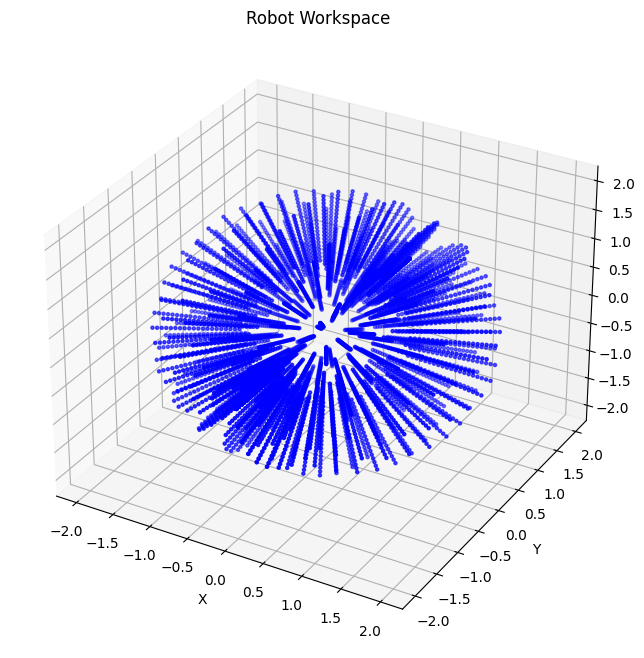

Workspace boundaries:
X: [-1.99, 1.99]
Y: [-2.00, 2.00]
Z: [-1.99, 1.97]
Approximate workspace volume: 62.91 cubic units


In [9]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Extract the position components
x = sf.simplify(sf.expand(clean_expression(end_effector_pose[0, 3]),Trig=True))
y = clean_expression(end_effector_pose[1, 3])
z = clean_expression(end_effector_pose[2, 3])


# Create lambda functions for x, y, z
x_func = sp.lambdify((joint_angles['q1'], joint_angles['q2'], joint_angles['q3'], L0), x)
y_func = sp.lambdify((joint_angles['q1'], joint_angles['q2'], joint_angles['q3'], L0), y)
z_func = sp.lambdify((joint_angles['q1'], joint_angles['q2'], joint_angles['q3'], L0), z)

# Define joint ranges
theta1_range = np.linspace(-np.pi, np.pi, 20)
theta2_range = np.linspace(-np.pi/2, np.pi/2, 20)
d_range = np.linspace(0, 1, 20)  # Assuming d can extend up to 1 unit

# Set L0 value
L0_value = 1.0  # Adjust as needed

workspace_points = []

for theta1 in theta1_range:
    for theta2 in theta2_range:
        for d in d_range:
            x_val = x_func(theta1, theta2, d, L0_value)
            y_val = y_func(theta1, theta2, d, L0_value)
            z_val = z_func(theta1, theta2, d, L0_value)
            workspace_points.append((x_val, y_val, z_val))

# Convert to numpy array for easier manipulation
workspace_points = np.array(workspace_points)

# Visualize the workspace
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(workspace_points[:, 0], workspace_points[:, 1], workspace_points[:, 2], c='b', marker='.')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace')

plt.show()

# Analyze workspace characteristics
x_min, x_max = np.min(workspace_points[:, 0]), np.max(workspace_points[:, 0])
y_min, y_max = np.min(workspace_points[:, 1]), np.max(workspace_points[:, 1])
z_min, z_max = np.min(workspace_points[:, 2]), np.max(workspace_points[:, 2])

print(f"Workspace boundaries:")
print(f"X: [{x_min:.2f}, {x_max:.2f}]")
print(f"Y: [{y_min:.2f}, {y_max:.2f}]")
print(f"Z: [{z_min:.2f}, {z_max:.2f}]")

# Approximate workspace volume
volume = (x_max - x_min) * (y_max - y_min) * (z_max - z_min)
print(f"Approximate workspace volume: {volume:.2f} cubic units")

# Jacobian Calculation for 3-DOF Robot

This section describes the process of calculating the Jacobian matrix for our 3-DOF robot. The Jacobian is a fundamental tool in robotics that relates joint-space velocities to end-effector velocities in Cartesian space.

## Process Overview

1. **Joint Variable Extraction**: We begin by isolating the individual joint variables from our robot model. These include two rotational joint angles (θ₁ and θ₂) and one prismatic joint extension (d).

2. **Symbolic Joint Vector Creation**: Using these joint variables, we construct a symbolic vector that represents the robot's configuration in joint space. This vector encapsulates the complete state of the robot's joints.

3. **End-Effector Position Extraction**: From our forward kinematics calculations, we extract the position vector of the end-effector. This vector represents the x, y, and z coordinates of the end-effector in Cartesian space.

4. **Jacobian Computation**: Finally, we calculate the Jacobian matrix by determining how small changes in each joint variable affect the end-effector's position. This involves taking partial derivatives of the end-effector position with respect to each joint variable.

## Significance of the Jacobian

The Jacobian matrix is crucial in robotics for several reasons:

1. **Velocity Analysis**: It allows us to convert joint velocities to end-effector velocities in Cartesian space.
2. **Force/Torque Transformation**: The Jacobian helps in transforming forces and torques between joint space and Cartesian space.
3. **Singularity Analysis**: By examining the Jacobian, we can identify singular configurations where the robot loses degrees of freedom.
4. **Manipulability Analysis**: The Jacobian is used to assess how well the robot can move in different directions from a given configuration.
5. **Inverse Kinematics**: In numerical methods for inverse kinematics, the Jacobian plays a key role in iteratively solving for joint angles.
6. **Control Algorithms**: Many advanced control strategies, especially those involving Cartesian space control, rely on the Jacobian.

By calculating and analyzing the Jacobian, we gain deep insights into the robot's kinematic behavior. This understanding is fundamental for advanced analysis, control strategies, and optimizing the robot's performance in various tasks.

In [10]:
# Use your joint variables
theta1 = joint_angles['q1']
theta2 = joint_angles['q2']
d = joint_angles['q3']


# Create the symbolic vector using your joint variables
joint_angles_sym = sf.V3(theta1, theta2, d)
joint_angles_sym

# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Calculate the Jacobian
jacobian = end_effector_position.jacobian(joint_angles_sym)

jacobian

⎡   ⎛                ⎛   ____________________________⎞     ⎛   _______________
⎢   ⎜                ⎜  ╱   2                        ⎟     ⎜  ╱   2           
⎢   ⎜      2   2    2⎜╲╱  θ₁  + 4.93038065763132e-30 ⎟    2⎜╲╱  θ₂  + 4.930380
⎢   ⎜1.0⋅θ₁ ⋅θ₂ ⋅sin ⎜───────────────────────────────⎟⋅sin ⎜──────────────────
⎢   ⎜                ⎝               2               ⎠     ⎝               2  
⎢L₀⋅⎜─────────────────────────────────────────────────────────────────────────
⎢   ⎜               ⎛  2                       ⎞ ⎛  2                       ⎞ 
⎢   ⎜               ⎝θ₁  + 4.93038065763132e-30⎠⋅⎝θ₂  + 4.93038065763132e-30⎠ 
⎢   ⎝                                                                         
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

# Singularity Analysis in Robot Workspace

This section describes the process of analyzing the robot's workspace and identifying singular configurations. Singularities are important to understand as they represent configurations where the robot loses one or more degrees of freedom, potentially affecting its performance and control.

## Process Overview

1. **Robot Setup**: We begin by setting up our 3-DOF robot model, including joint angles, screw axes parameters, and initial transformation.

2. **Jacobian Calculation**: We calculate the Jacobian matrix, which relates joint velocities to end-effector velocities. This is crucial for identifying singularities.

3. **Workspace Sampling**: We define ranges for each joint and sample points within these ranges to explore the robot's workspace.

4. **Singularity Detection**: For each sampled configuration, we evaluate the Jacobian and check for singularities using Singular Value Decomposition (SVD).

5. **Data Collection**: We collect two sets of points:
   - Regular workspace points
   - Singular points (configurations where the robot is at or near a singularity)

6. **Visualization**: We create a 3D scatter plot to visualize the robot's workspace, distinguishing between regular and singular points.

7. **Analysis**: We perform a quantitative analysis of the workspace and singularities.

## Key Components

- **Jacobian Function**: We create a function to quickly evaluate the Jacobian for given joint angles.
- **Singularity Check**: We define a function to determine if a configuration is singular based on the condition number of the Jacobian.
- **Workspace Exploration**: We systematically explore the robot's joint space to map out its workspace.

## Visualization and Analysis

- The 3D scatter plot provides a visual representation of the robot's workspace.
- Regular points are shown in blue, representing the reachable workspace.
- Singular points, if any, are highlighted in red, indicating problematic configurations.
- We calculate and display:
  - Total number of sampled points
  - Number of singular points
  - Percentage of singular configurations
  - Center of the singular region (if applicable)

## Significance

This analysis is crucial for:
1. Understanding the robot's operational limits
2. Identifying regions of the workspace where the robot may face control difficulties
3. Informing path planning to avoid singular configurations
4. Providing insights for robot design improvements



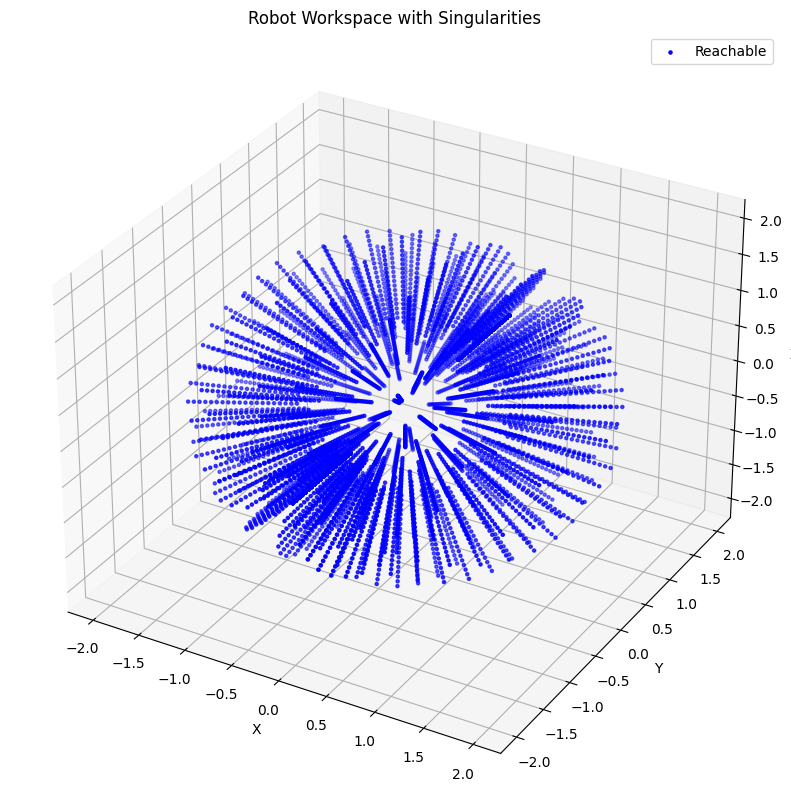

Total points: 8000
Singular points: 0
Percentage of singular configurations: 0.00%


In [11]:
import symforce.symbolic as sf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp

# Setup the robot
joint_angles, screw_axes_params, M_params, L0 = setup_3dof_robot()

# Extract the joint angle symbols
theta1 = joint_angles['q1']
theta2 = joint_angles['q2']
d = joint_angles['q3']

# Create the symbolic vector using your joint variables
joint_angles_sym = sf.V3(theta1, theta2, d)

# Use your calculated end-effector pose
end_effector_pose = n_link_forward_kinematics(joint_angles, screw_axes_params, M_params, epsilon)

# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Calculate the Jacobian
jacobian = end_effector_position.jacobian(joint_angles_sym)

# Convert SymForce matrices to SymPy matrices
end_effector_position_sympy = sp.Matrix(end_effector_position)
jacobian_sympy = sp.Matrix(jacobian)

# Create lambda functions for position and Jacobian
position_func = sp.lambdify([theta1, theta2, d, L0], end_effector_position_sympy)
jacobian_func = sp.lambdify([theta1, theta2, d, L0], jacobian_sympy)

def is_singular(J, threshold=1e-6):
    _, s, _ = np.linalg.svd(J)
    return np.any(s < threshold)

# Define joint ranges
theta1_range = np.linspace(-np.pi, np.pi, 20)
theta2_range = np.linspace(-np.pi/2, np.pi/2, 20)
d_range = np.linspace(0, 1, 20)

L0_value = 1.0  # Adjust as needed

workspace_points = []
singular_points = []

for theta1_val in theta1_range:
    for theta2_val in theta2_range:
        for d_val in d_range:
            position = position_func(theta1_val, theta2_val, d_val, L0_value)
            J = jacobian_func(theta1_val, theta2_val, d_val, L0_value)

            if is_singular(J):
                singular_points.append(position)
            else:
                workspace_points.append(position)

workspace_points = np.array(workspace_points)
singular_points = np.array(singular_points)


# Visualize the workspace
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(workspace_points[:, 0], workspace_points[:, 1], workspace_points[:, 2], c='b', marker='.', label='Reachable')
if len(singular_points) > 0:
    ax.scatter(singular_points[:, 0], singular_points[:, 1], singular_points[:, 2], c='r', marker='.', label='Singular')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace with Singularities')
ax.legend()

plt.show()

# Analyze workspace and singularities
print(f"Total points: {len(workspace_points) + len(singular_points)}")
print(f"Singular points: {len(singular_points)}")
print(f"Percentage of singular configurations: {len(singular_points) / (len(workspace_points) + len(singular_points)) * 100:.2f}%")

if len(singular_points) > 0:
    singular_mean = np.mean(singular_points, axis=0)
    print(f"Center of singular region: ({singular_mean[0]:.2f}, {singular_mean[1]:.2f}, {singular_mean[2]:.2f})")

# Workspace and Inverse Kinematics Analysis for 3-DOF Robot

This section describes a comprehensive analysis of the robot's workspace and inverse kinematics solutions. The analysis provides insights into the robot's operational capabilities, reachable positions, and the validity of inverse kinematics solutions across the workspace.

## Process Overview

1. **Robot Setup**: We initialize the 3-DOF robot model, including joint angles, screw axes parameters, and initial transformation.

2. **Forward Kinematics**: We use the previously calculated forward kinematics to determine the end-effector position for given joint configurations.

3. **Inverse Kinematics**: We utilize the inverse kinematics solutions obtained earlier to analyze the robot's workspace.

4. **Workspace Sampling**: We define a 3D grid of points in Cartesian space to sample the potential workspace.

5. **Solution Validation**: For each sampled point, we check if valid inverse kinematics solutions exist.

6. **Data Collection**: We categorize points as either:
   - Valid (reachable with real joint angles)
   - Invalid (unreachable or only reachable with complex joint angles)

7. **Visualization**: We create a 3D scatter plot to visualize the robot's workspace, distinguishing between valid and invalid points.

8. **Workspace Analysis**: We perform a quantitative analysis of the workspace characteristics.

## Key Components

- **Real Solution Check**: We implement a function to filter out complex solutions and retain only real, physically meaningful joint configurations.
- **Inverse Kinematics Evaluation**: We evaluate the inverse kinematics solutions for each sampled point in the potential workspace.
- **Workspace Mapping**: We systematically explore the Cartesian space to determine the robot's reachable workspace.

## Visualization and Analysis

- The 3D scatter plot provides a visual representation of the robot's workspace:
  - Blue points represent valid, reachable positions.
  - Red points, if any, indicate invalid or unreachable positions.
- We calculate and display:
  - Total number of sampled points
  - Number of valid (reachable) points
  - Number of invalid (unreachable) points
  - Percentage of the sampled space that is reachable
  - Boundaries of the valid workspace in X, Y, and Z dimensions
  - Center of the invalid region (if applicable)

## Significance

This analysis is crucial for:
1. Understanding the robot's operational range and limitations
2. Identifying regions where the robot can effectively operate
3. Recognizing areas that are outside the robot's reach or lead to invalid configurations
4. Informing task planning and robot placement for specific applications
5. Providing insights for potential robot design improvements or modifications


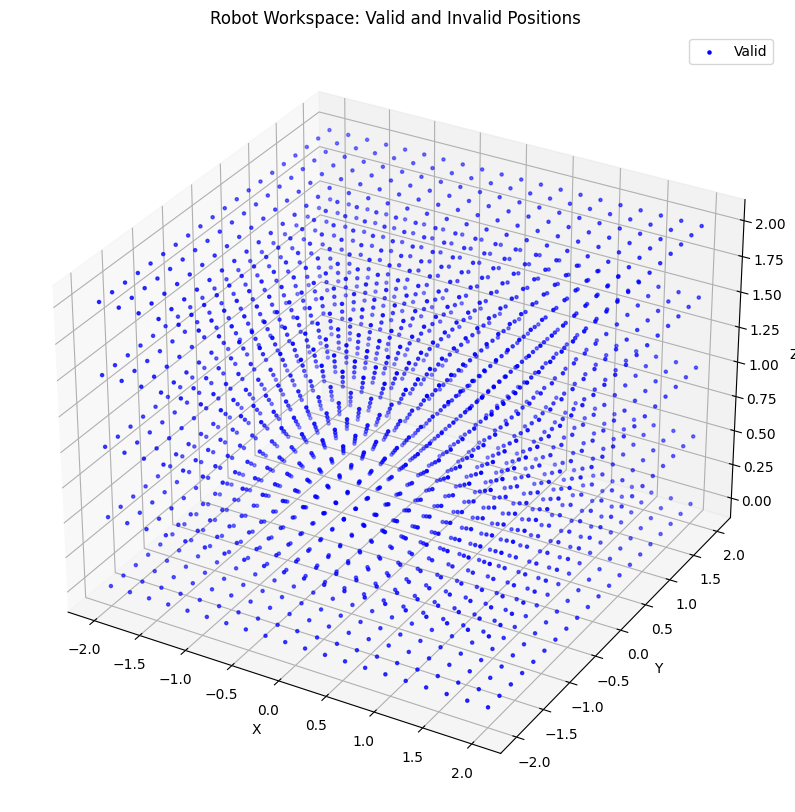

Total points sampled: 2000
Valid points: 2000
Invalid points: 0
Percentage of valid workspace: 100.00%

Valid workspace boundaries:
X: [-2.00, 2.00]
Y: [-2.00, 2.00]
Z: [0.00, 2.00]


In [12]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sympy as sp

def get_real_solutions(solutions, tolerance=1e-9):
    """
    Get all real solutions from the set of solutions.

    Args:
    solutions: A list of solutions to check
    tolerance: The maximum allowed absolute value for the imaginary part (default: 1e-9)

    Returns:
    list: A list of real solutions
    """
    def is_real(solution):
        return all(abs(sp.im(s).evalf()) < tolerance for s in solution)

    return [sol for sol in solutions if is_real(sol)]


# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Convert SymForce matrices to SymPy matrices
end_effector_position_sympy = sp.Matrix(end_effector_position)

# Create lambda function for position
position_func = sp.lambdify([theta1, theta2, d, L0], end_effector_position_sympy)

# Define ranges for workspace sampling
x_range = np.linspace(-2, 2, 20)
y_range = np.linspace(-2, 2, 20)
z_range = np.linspace(0, 2, 5)

L0_value = 1.0  # Adjust as needed



# Extract x, y, z symbols from the end-effector position
x, y, z = sp.symbols('x_target y_target z_target')

valid_points = []
valid_solutions = []
invalid_points = []

for x_val in x_range:
    for y_val in y_range:
        for z_val in z_range:
            # Substitute the current x, y, z values into the inverse kinematics solutions
            substituted_solutions = [
                [s.subs({x: x_val, y: y_val, z: z_val, L0: L0_value}) for s in sol]
                for sol in ik_solution
            ]

            # Get real solutions
            real_solutions = get_real_solutions(substituted_solutions)

            if real_solutions:
                valid_points.append((x_val, y_val, z_val))
                valid_solutions.append(real_solutions)
            else:
                invalid_points.append((x_val, y_val, z_val))

valid_points = np.array(valid_points)
invalid_points = np.array(invalid_points)


# Visualize the workspace
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

if len(valid_points) > 0:
    ax.scatter(valid_points[:, 0], valid_points[:, 1], valid_points[:, 2], c='b', marker='.', label='Valid')
if len(invalid_points) > 0:
    ax.scatter(invalid_points[:, 0], invalid_points[:, 1], invalid_points[:, 2], c='r', marker='.', label='Invalid')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace: Valid and Invalid Positions')
ax.legend()

plt.show()

# Analyze workspace
total_points = len(valid_points) + len(invalid_points)
print(f"Total points sampled: {total_points}")
print(f"Valid points: {len(valid_points)}")
print(f"Invalid points: {len(invalid_points)}")
print(f"Percentage of valid workspace: {len(valid_points) / total_points * 100:.2f}%")

if len(valid_points) > 0:
    print("\nValid workspace boundaries:")
    print(f"X: [{np.min(valid_points[:, 0]):.2f}, {np.max(valid_points[:, 0]):.2f}]")
    print(f"Y: [{np.min(valid_points[:, 1]):.2f}, {np.max(valid_points[:, 1]):.2f}]")
    print(f"Z: [{np.min(valid_points[:, 2]):.2f}, {np.max(valid_points[:, 2]):.2f}]")

if len(invalid_points) > 0:
    print("\nInvalid points center:")
    invalid_center = np.mean(invalid_points, axis=0)
    print(f"({invalid_center[0]:.2f}, {invalid_center[1]:.2f}, {invalid_center[2]:.2f})")

In [30]:
[k.evalf() for k in valid_solutions[1][1]]

[1.81577498992176 - 2.16586762356905e-15⋅ⅈ, 2.37134832517544 - 2.7060912070980
3e-16⋅ⅈ, 1.87228132326901 - 8.01186962950885e-16⋅ⅈ]

# Comprehensive Robot Workspace and Singularity Analysis

This section describes a detailed analysis of the robot's workspace, including the identification of singular configurations and the validation of inverse kinematics solutions. The process involves several key steps and analyses, providing a thorough understanding of the robot's operational capabilities and limitations.

## 1. Jacobian Calculation and Singularity Analysis

- We calculate the Jacobian matrix, which relates joint velocities to end-effector velocities.
- A function is defined to check for singularities using Singular Value Decomposition (SVD) of the Jacobian.
- The workspace is sampled by iterating through ranges of joint angles.
- Points are classified as either regular or singular based on the Jacobian analysis.

## 2. Inverse Kinematics and Workspace Validation

- We use previously calculated inverse kinematics solutions to analyze the robot's workspace.
- A function is implemented to filter out complex solutions, retaining only real, physically meaningful joint configurations.
- The workspace is sampled in Cartesian space, and each point is checked for valid inverse kinematics solutions.
- Points are categorized as valid (reachable) or invalid (unreachable) based on the existence of real solutions.

## 3. Visualization

- Two 3D scatter plots are created to visualize the robot's workspace:
  1. Regular vs. Singular points
  2. Valid vs. Invalid points
- These visualizations provide intuitive understanding of the robot's operational space and its limitations.

## 4. Quantitative Analysis

For both the singularity and inverse kinematics analyses, we calculate and display:
- Total number of sampled points
- Number of regular/valid points
- Number of singular/invalid points
- Percentage of singular configurations or valid workspace
- Boundaries of the valid workspace (for inverse kinematics analysis)
- Center of singular or invalid regions (if applicable)

## Key Insights

1. **Workspace Mapping**: The analysis provides a comprehensive map of the robot's reachable space, including areas prone to singularities.

2. **Singularity Identification**: By identifying singular configurations, we can understand where the robot might lose degrees of freedom or face control difficulties.

3. **Inverse Kinematics Validation**: The analysis of valid and invalid points helps in understanding the practical limitations of the robot's reach.

4. **Performance Prediction**: The distribution of singular and invalid points can help predict the robot's performance in different regions of its workspace.

5. **Design Insights**: This analysis can inform potential improvements in robot design or modifications to expand its effective workspace.

6. **Operational Planning**: Understanding the workspace characteristics is crucial for task planning and optimal robot placement for specific applications.


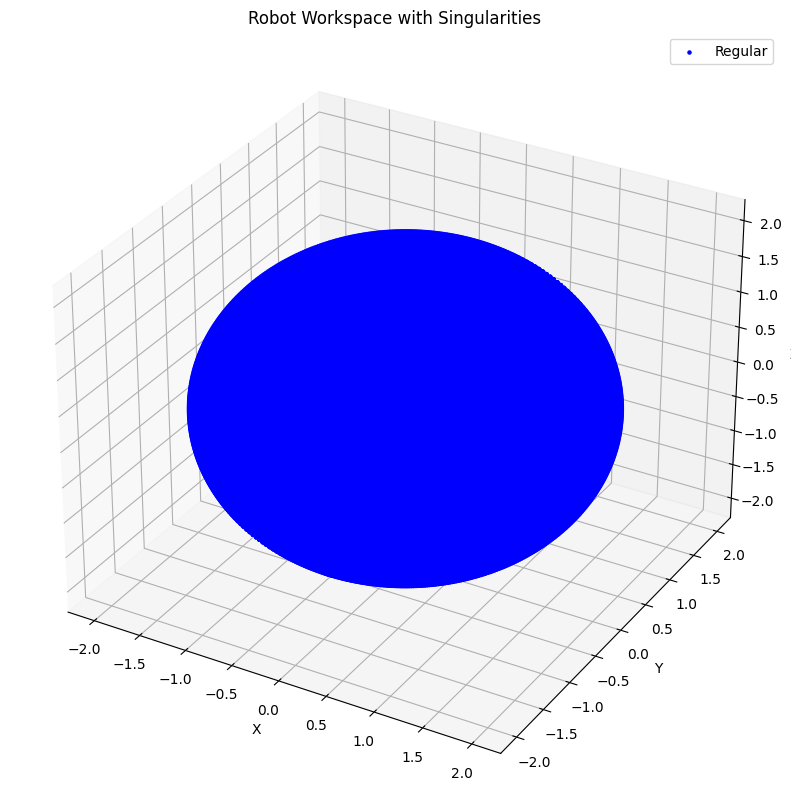

Total points: 400000
Regular points: 400000
Singular points: 0
Percentage of singular configurations: 0.00%


In [13]:
# Extract the position from the end-effector pose
end_effector_position = end_effector_pose[:3, 3]

# Calculate the Jacobian
jacobian = end_effector_position.jacobian(joint_angles_sym)

# Convert SymForce matrices to SymPy matrices
end_effector_position_sympy = sp.Matrix(end_effector_position)
jacobian_sympy = sp.Matrix(jacobian)

# Create lambda functions for position and Jacobian
position_func = sp.lambdify([theta1, theta2, d, L0], end_effector_position_sympy)
jacobian_func = sp.lambdify([theta1, theta2, d, L0], jacobian_sympy)

def is_singular(J, threshold=1e-6):
    # Check if the Jacobian is singular
    _, s, _ = np.linalg.svd(J)
    return np.any(s < threshold)

# Define joint ranges
theta1_range = np.linspace(-np.pi, np.pi, 200)
theta2_range = np.linspace(-np.pi/2, np.pi/2, 200)
d_range = np.linspace(0, 1, 10)

L0_value = 1.0  # Adjust as needed

regular_points = []
singular_points = []

for theta1_val in theta1_range:
    for theta2_val in theta2_range:
        for d_val in d_range:
            # Calculate position and Jacobian
            position = position_func(theta1_val, theta2_val, d_val, L0_value)
            J = jacobian_func(theta1_val, theta2_val, d_val, L0_value)

            # Check if the configuration is singular
            if is_singular(J):
                singular_points.append(position)
            else:
                regular_points.append(position)

regular_points = np.array(regular_points)
singular_points = np.array(singular_points)

# Visualize the workspace
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(regular_points[:, 0], regular_points[:, 1], regular_points[:, 2], c='b', marker='.', label='Regular')
if len(singular_points) > 0:
    ax.scatter(singular_points[:, 0], singular_points[:, 1], singular_points[:, 2], c='r', marker='.', label='Singular')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Robot Workspace with Singularities')
ax.legend()

plt.show()

# Analyze workspace and singularities
total_points = len(regular_points) + len(singular_points)
print(f"Total points: {total_points}")
print(f"Regular points: {len(regular_points)}")
print(f"Singular points: {len(singular_points)}")
print(f"Percentage of singular configurations: {len(singular_points) / total_points * 100:.2f}%")

if len(singular_points) > 0:
    singular_mean = np.mean(singular_points, axis=0)
    print(f"\nCenter of singular region: ({singular_mean[0]:.2f}, {singular_mean[1]:.2f}, {singular_mean[2]:.2f})")